In [1]:
pip install torch gym matplotlib numpy

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 10, Reward: 10.0, Avg Reward: 9.30
Episode 20, Reward: 9.0, Avg Reward: 9.45
Episode 30, Reward: 10.0, Avg Reward: 9.57
Episode 40, Reward: 9.0, Avg Reward: 9.50
Episode 50, Reward: 10.0, Avg Reward: 9.46
Episode 60, Reward: 11.0, Avg Reward: 9.45
Episode 70, Reward: 8.0, Avg Reward: 9.47
Episode 80, Reward: 10.0, Avg Reward: 9.46
Episode 90, Reward: 9.0, Avg Reward: 9.43
Episode 100, Reward: 10.0, Avg Reward: 9.45


<ipython-input-2-fdc232d00733>:152: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.FloatTensor(batch.state).to(device)


Episode 110, Reward: 9.0, Avg Reward: 9.57
Episode 120, Reward: 17.0, Avg Reward: 10.42
Episode 130, Reward: 9.0, Avg Reward: 11.88
Episode 140, Reward: 17.0, Avg Reward: 12.66
Episode 150, Reward: 27.0, Avg Reward: 14.08
Episode 160, Reward: 13.0, Avg Reward: 15.19
Episode 170, Reward: 11.0, Avg Reward: 15.81
Episode 180, Reward: 15.0, Avg Reward: 16.23
Episode 190, Reward: 18.0, Avg Reward: 16.65
Episode 200, Reward: 11.0, Avg Reward: 17.08
Episode 210, Reward: 10.0, Avg Reward: 17.37
Episode 220, Reward: 10.0, Avg Reward: 16.82
Episode 230, Reward: 21.0, Avg Reward: 16.07
Episode 240, Reward: 14.0, Avg Reward: 15.98
Episode 250, Reward: 34.0, Avg Reward: 15.59
Episode 260, Reward: 9.0, Avg Reward: 15.48
Episode 270, Reward: 30.0, Avg Reward: 16.07
Episode 280, Reward: 15.0, Avg Reward: 16.28
Episode 290, Reward: 15.0, Avg Reward: 18.29
Episode 300, Reward: 25.0, Avg Reward: 21.14
Episode 310, Reward: 239.0, Avg Reward: 28.31
Episode 320, Reward: 326.0, Avg Reward: 45.42
Episode 330,

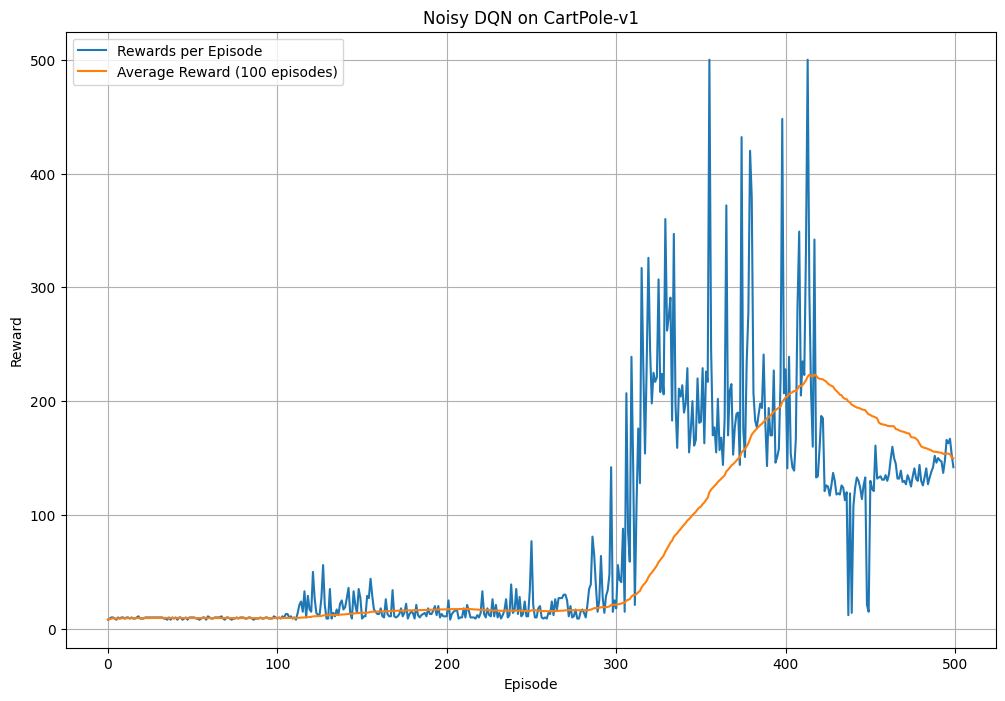

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Noisy Linear Layer
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Learnable parameters
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # Register buffers for noise
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.sigma_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.sigma_init / math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

    @staticmethod
    def _scale_noise(size):
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())

# Noisy DQN Network
class NoisyDQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(NoisyDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.noisy_fc2 = NoisyLinear(128, 128)
        self.noisy_fc3 = NoisyLinear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.noisy_fc2(x))
        return self.noisy_fc3(x)

    def reset_noise(self):
        self.noisy_fc2.reset_noise()
        self.noisy_fc3.reset_noise()

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, params):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = params.get('gamma', 0.99)
        self.batch_size = params.get('batch_size', 64)
        self.lr = params.get('lr', 1e-3)
        self.buffer_capacity = params.get('buffer_capacity', 10000)
        self.min_buffer_size = params.get('min_buffer_size', 1000)
        self.target_update_freq = params.get('target_update_freq', 1000)
        self.epsilon = params.get('epsilon', 0.1)  # Not used in Noisy DQN
        self.learn_step_counter = 0

        # Networks
        self.policy_net = NoisyDQN(state_dim, action_dim).to(device)
        self.target_net = NoisyDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Loss
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

        # Replay Buffer
        self.replay_buffer = ReplayBuffer(self.buffer_capacity)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        action = q_values.max(1)[1].item()
        return action

    def push_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def learn(self):
        if len(self.replay_buffer) < self.min_buffer_size:
            return

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state = torch.FloatTensor(batch.state).to(device)
        action = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(batch.next_state).to(device)
        done = torch.FloatTensor(batch.done).unsqueeze(1).to(device)

        # Current Q values
        q_values = self.policy_net(state).gather(1, action)

        # Next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_net(next_state).max(1)[0].unsqueeze(1)
            target_q_values = reward + (1 - done) * self.gamma * next_q_values

        # Compute loss
        loss = self.criterion(q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Reset noise
        self.policy_net.reset_noise()
        self.target_net.reset_noise()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Parameters
params = {
    'gamma': 0.99,
    'batch_size': 64,
    'lr': 1e-3,
    'buffer_capacity': 10000,
    'min_buffer_size': 1000,
    'target_update_freq': 1000,
    'epsilon': 0.1  # Not used in Noisy DQN
}

# Initialize Environment
env = gym.make('CartPole-v1')
env.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, params)

# Training Loop
num_episodes = 500
max_steps = 500
rewards = []
avg_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        agent.push_transition(state, action, reward, next_state, done)
        agent.learn()

        state = next_state
        episode_reward += reward

        if done:
            break

    rewards.append(episode_reward)
    avg_reward = np.mean(rewards[-100:])
    avg_rewards.append(avg_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}, Avg Reward: {avg_reward:.2f}")

    # Early stopping if environment is solved
    if avg_reward >= 475.0 and episode >= 100:
        print(f"Environment solved in {episode} episodes!")
        break

env.close()

# Plotting the Rewards
plt.figure(figsize=(12,8))
plt.plot(rewards, label='Rewards per Episode')
plt.plot(avg_rewards, label='Average Reward (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Noisy DQN on CartPole-v1')
plt.legend()
plt.grid()
plt.show()
